# Phase 2: Portfolio Backtesting

Explore multi-asset portfolio strategies with different allocations:
- **Equal-weight**: Split capital evenly across all assets
- **Custom allocation**: 60/30/10 split (stocks/bonds/gold)
- **Rebalancing**: Compare monthly vs quarterly rebalancing
- **Factor-weighted**: Use Momentum to dynamically adjust weights

We use a simple 3-asset universe: SPY (stocks), BND (bonds), GLD (gold).


In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import pandas as pd

from qlib.backtesting import PortfolioBacktester
from qlib.data import DataLoader
from qlib.factors import Momentum
from qlib.metrics import max_drawdown, sharpe, sortino

plt.style.use("seaborn-v0_8")

In [2]:
symbols = ["SPY", "BND", "GLD"]
start = "2015-01-01"

print(f"Loading universe: {symbols} starting {start}...")
universe = DataLoader.load_universe(symbols, start=start)
universe.head()

Loading universe: ['SPY', 'BND', 'GLD'] starting 2015-01-01...


/Users/josh/alpha/qlib/data/loader.py:88: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df: DataFrame = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/Users/josh/alpha/qlib/data/loader.py:88: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df: DataFrame = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/Users/josh/alpha/qlib/data/loader.py:88: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df: DataFrame = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


SPY                                                 \
                  open        high         low       close     volume   
datetime                                                                
2015-01-02  171.884943  172.301372  170.052649  171.093719  121465900   
2015-01-05  170.044311  170.210879  167.695662  168.003815  169632600   
2015-01-06  168.311993  168.836696  165.621869  166.421417  209151400   
2015-01-07  167.753921  168.836637  167.304185  168.495163  125346700   
2015-01-08  169.911070  171.701719  169.894422  171.485168  147217800   

                  BND                                                   GLD  \
                 open       high        low      close   volume        open   
datetime                                                                      
2015-01-02  60.620038  60.811247  60.612683  60.781830  2218800  112.489998   
2015-01-05  60.848008  60.980382  60.818590  60.958321  5820100  114.779999   
2015-01-06  61.061245  61.318638  61.061245  61.134785  3887600  116.220001   
2015-01-07  61.142191  61.245148  61.076006  61.171608  2433400  116.470001   
2015-01-08  61.120085  61.120085  61.017128  61.075962  1873400  116.449997   

                                                          
                  high         low       close    volume  
datetime                                                  
2015-01-02  114.800003  112.320000  114.080002   7109600  
2015-01-05  116.000000  114.730003  115.800003   8177400  
2015-01-06  117.500000  115.800003  117.120003  11238300  
2015-01-07  116.879997  116.169998  116.430000   6434200  
2015-01-08  116.870003  115.849998  115.940002   7033700

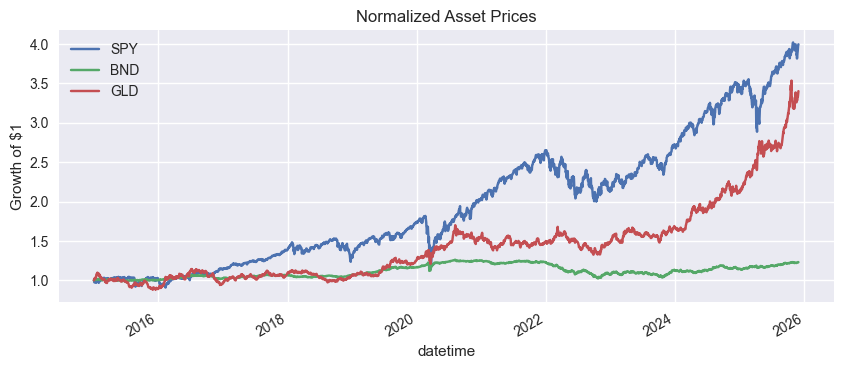

In [3]:
# Extract close prices for plotting
close_prices = universe.xs("close", axis=1, level=1)

# Normalize to $1 start for comparison
normalized = close_prices / close_prices.iloc[0]

ax = normalized.plot(figsize=(10, 4), title="Normalized Asset Prices")
ax.set_ylabel("Growth of $1")
plt.show()

## Equal-Weight Portfolio

The simplest allocation: split capital evenly across all three assets (33% each). Rebalance monthly to maintain the allocation.

In [4]:
bt_equal = PortfolioBacktester(universe, weights=None, rebalance_freq="ME")
rets_equal = bt_equal.run().dropna()

metrics_equal = {
    "sharpe": sharpe(rets_equal),
    "sortino": sortino(rets_equal),
    "max_drawdown": max_drawdown(rets_equal),
}
metrics_equal

{'sharpe': np.float64(1.1167733670555307),
 'sortino': np.float64(1.6109102188368771),
 'max_drawdown': np.float64(-0.16349924717760217)}

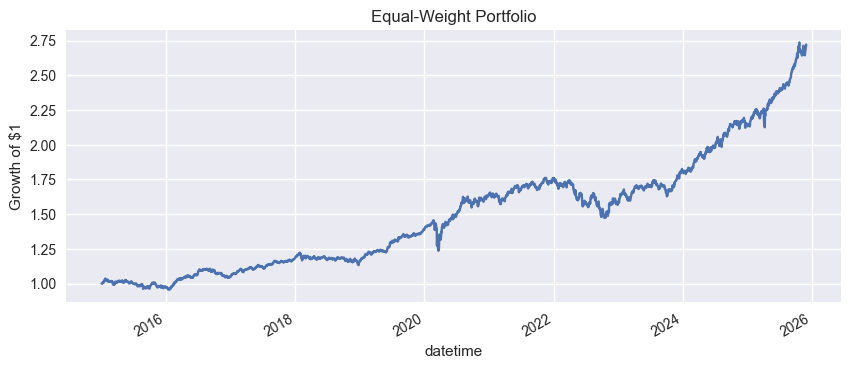

In [5]:
cum_equal = (1 + rets_equal).cumprod()
ax = cum_equal.plot(figsize=(10, 4), title="Equal-Weight Portfolio")
ax.set_ylabel("Growth of $1")
plt.show()

## Custom Allocation: 60/30/10

A classic allocation tilted toward stocks:
- 60% SPY (stocks)
- 30% BND (bonds)
- 10% GLD (gold)

In [6]:
custom_weights = {"SPY": 0.6, "BND": 0.3, "GLD": 0.1}
bt_custom = PortfolioBacktester(universe, weights=custom_weights, rebalance_freq="ME")
rets_custom = bt_custom.run().dropna()

metrics_custom = {
    "sharpe": sharpe(rets_custom),
    "sortino": sortino(rets_custom),
    "max_drawdown": max_drawdown(rets_custom),
}
metrics_custom

{'sharpe': np.float64(0.9297607871860962),
 'sortino': np.float64(1.3191032424871743),
 'max_drawdown': np.float64(-0.21931663346445165)}

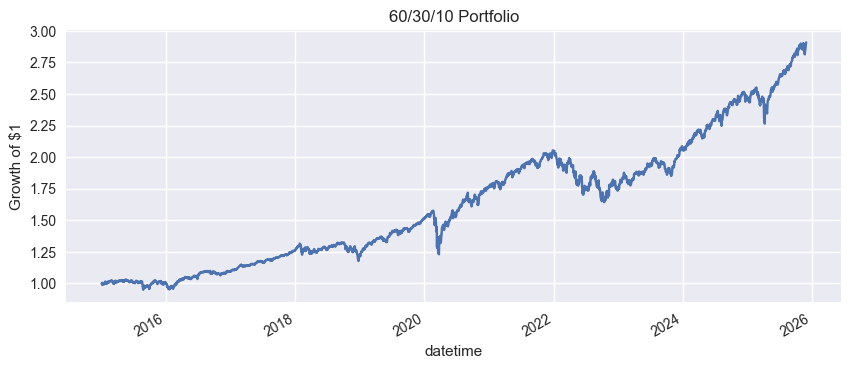

In [7]:
cum_custom = (1 + rets_custom).cumprod()
ax = cum_custom.plot(figsize=(10, 4), title="60/30/10 Portfolio")
ax.set_ylabel("Growth of $1")
plt.show()

## Rebalancing Frequency

Compare monthly vs quarterly rebalancing on the 60/30/10 portfolio. More frequent rebalancing maintains target weights but incurs more trading costs.

In [8]:
bt_monthly = PortfolioBacktester(universe, weights=custom_weights, rebalance_freq="ME")
bt_quarterly = PortfolioBacktester(universe, weights=custom_weights, rebalance_freq="QE")

rets_monthly = bt_monthly.run().dropna()
rets_quarterly = bt_quarterly.run().dropna()

metrics_monthly = {
    "sharpe": sharpe(rets_monthly),
    "sortino": sortino(rets_monthly),
    "max_drawdown": max_drawdown(rets_monthly),
}
metrics_quarterly = {
    "sharpe": sharpe(rets_quarterly),
    "sortino": sortino(rets_quarterly),
    "max_drawdown": max_drawdown(rets_quarterly),
}

print("Monthly rebalancing:", metrics_monthly)
print("Quarterly rebalancing:", metrics_quarterly)

Monthly rebalancing: {'sharpe': np.float64(0.9297607871860962), 'sortino': np.float64(1.3191032424871743), 'max_drawdown': np.float64(-0.21931663346445165)}
Quarterly rebalancing: {'sharpe': np.float64(0.9297607871860962), 'sortino': np.float64(1.3191032424871743), 'max_drawdown': np.float64(-0.21931663346445165)}


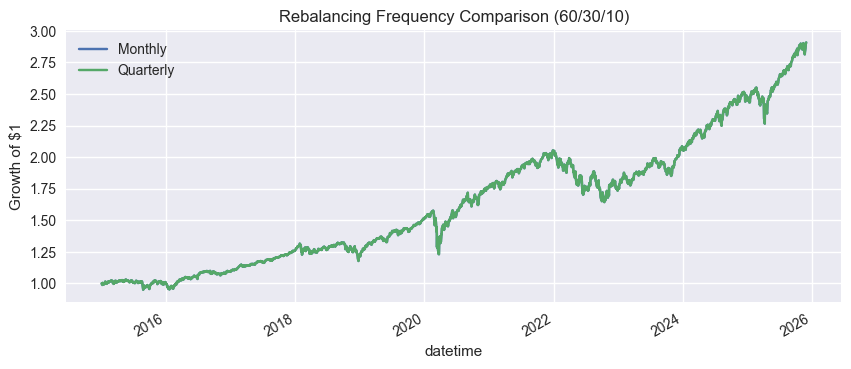

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))
(1 + rets_monthly).cumprod().plot(ax=ax, label="Monthly")
(1 + rets_quarterly).cumprod().plot(ax=ax, label="Quarterly")
ax.set_title("Rebalancing Frequency Comparison (60/30/10)")
ax.set_ylabel("Growth of $1")
ax.legend()
plt.show()

## Factor-Weighted Portfolio

Instead of fixed weights, use Momentum to dynamically allocate. Assets with positive momentum get higher weights, negative momentum get lower or zero weights.

In [10]:
# Compute momentum for each asset
lookback = 20
factor = Momentum(lookback=lookback)

momentum_signals = pd.DataFrame(index=universe.index)
for symbol in symbols:
    asset_data = universe[symbol]
    momentum_signals[symbol] = factor.compute(asset_data)

# Convert momentum to positive weights (clip negative to zero)
# This creates a "long-only momentum" strategy
positive_momentum = momentum_signals.clip(lower=0)

momentum_signals.tail()

,SPY,BND,GLD
datetime,,,
2025-11-21,-0.026903,-0.003404,-0.008609
2025-11-24,-0.024094,-0.002198,0.035939
2025-11-25,-0.017524,-0.000458,0.043087
2025-11-26,-0.011216,0.005565,0.055427
2025-11-28,0.005237,0.005703,0.047956


In [11]:
bt_momentum = PortfolioBacktester(universe)
rets_momentum = bt_momentum.run(signals=positive_momentum).dropna()

metrics_momentum = {
    "sharpe": sharpe(rets_momentum),
    "sortino": sortino(rets_momentum),
    "max_drawdown": max_drawdown(rets_momentum),
}
metrics_momentum

{'sharpe': np.float64(0.5826446454746458),
 'sortino': np.float64(0.8018063450616959),
 'max_drawdown': np.float64(-0.20275979632638244)}

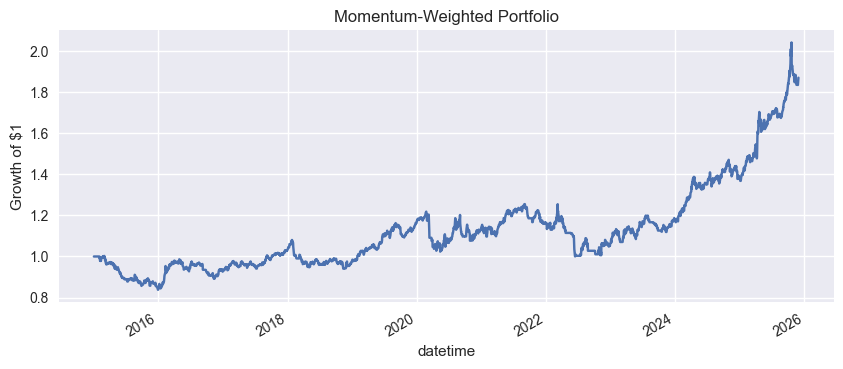

In [12]:
cum_momentum = (1 + rets_momentum).cumprod()
ax = cum_momentum.plot(figsize=(10, 4), title="Momentum-Weighted Portfolio")
ax.set_ylabel("Growth of $1")
plt.show()

## Strategy Comparison

Compare all strategies side by side.

In [13]:
comparison = pd.DataFrame(
    {
        "Equal-Weight": metrics_equal,
        "60/30/10": metrics_custom,
        "Monthly Rebal": metrics_monthly,
        "Quarterly Rebal": metrics_quarterly,
        "Momentum": metrics_momentum,
    }
).T

comparison.round(3)

,sharpe,sortino,max_drawdown
Equal-Weight,1.117,1.611,-0.163
60/30/10,0.930,1.319,-0.219
Monthly Rebal,0.930,1.319,-0.219
Quarterly Rebal,0.930,1.319,-0.219
Momentum,0.583,0.802,-0.203


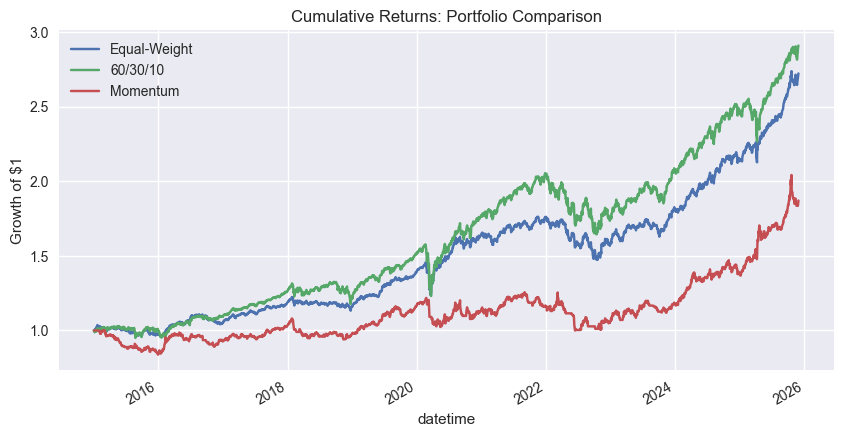

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))

(1 + rets_equal).cumprod().plot(ax=ax, label="Equal-Weight")
(1 + rets_custom).cumprod().plot(ax=ax, label="60/30/10")
(1 + rets_momentum).cumprod().plot(ax=ax, label="Momentum")

ax.set_title("Cumulative Returns: Portfolio Comparison")
ax.set_ylabel("Growth of $1")
ax.legend()
plt.show()